Data Cleaning Pipeline

In [1]:
import rsf_occupancy_collector as rsf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px

In [2]:
def get_df():
    sheet = rsf.setup_google_sheets()
    values = sheet.get_all_values()
    headers = values[0]
    rsf_df = pd.DataFrame(values[1:], columns=headers)
    return rsf_df

def filter_gym_data():
    #Only keep data points recorded after spring break (>= 31st)
    df = get_df()
    date_format = '%m/%d/%Y %I:%M:%p'
    #Convert columns to consistent datatypes
    df['pst_timestamp'] = pd.to_datetime(df['pst_timestamp'], format=date_format)
    df['percentage_capacity'] = df['percentage_capacity'].astype(float)
    spring_break_end = pd.Timestamp('2025-03-31')
    df = df[df['pst_timestamp'] >= spring_break_end]
    #Only keep data points recorded within hours of operation (due to issues with github workflow)
    df = df[(df['pst_timestamp'].dt.hour >= 7) & (df['pst_timestamp'].dt.hour < 23)]
    #Remove data points where the gym is 0% full
    df = df[df['percentage_capacity'] > 0]
    return df

data = filter_gym_data()

In [3]:
#Each row represents a reading from the RSF crowd meter sensor starting from March 31st 2025
data

,timestamp,percentage_capacity,pst_timestamp
374,2025-03-31 15:19:18,48.00,2025-03-31 08:19:00
375,2025-03-31 15:37:08,56.00,2025-03-31 08:37:00
376,2025-03-31 15:47:45,54.67,2025-03-31 08:47:00
377,2025-03-31 16:22:56,56.67,2025-03-31 09:22:00
378,2025-03-31 16:52:37,53.33,2025-03-31 09:52:00
...,...,...,...
613,2025-04-06 22:46:33,55.33,2025-04-06 15:46:00
614,2025-04-06 23:17:54,67.33,2025-04-06 16:17:00
615,2025-04-06 23:30:13,69.33,2025-04-06 16:30:00
616,2025-04-06 23:46:33,71.33,2025-04-06 16:46:00


Scope
- On average, what day of the week is the rsf most busy? least busy?
- Each day, at what hour is the rsf least busy?


In [4]:
# Average occupancy by hour
data['hour'] = [f'{tstamp.hour} AM' if tstamp.hour < 12 else f'{tstamp.hour - 12} PM' for tstamp in data['pst_timestamp']]
avg_by_hour = data.groupby('hour')['percentage_capacity'].mean().sort_values()

# Average occupancy by day of week
data['weekday'] = data['pst_timestamp'].dt.day_name()
avg_by_weekday = data.groupby('weekday')['percentage_capacity'].mean().sort_values()

In [5]:
print(avg_by_weekday, avg_by_hour)

weekday
Sunday       52.820000
Friday       61.272424
Monday       65.720323
Thursday     65.853750
Wednesday    66.902353
Saturday     67.482222
Tuesday      69.607059
Name: percentage_capacity, dtype: float64 hour
7 AM     36.443333
10 PM    42.166667
8 AM     47.048095
9 AM     55.458125
1 PM     61.718947
10 AM    61.873810
2 PM     65.565000
0 PM     65.618095
11 AM    68.134000
7 PM     72.000000
3 PM     73.100000
8 PM     74.082500
9 PM     78.268000
4 PM     80.699500
5 PM     85.776667
6 PM     86.890000
Name: percentage_capacity, dtype: float64


In [6]:
heatmap_pivot = data.pivot_table(index='weekday', columns='hour', values='percentage_capacity', aggfunc='mean')
heatmap_pivot

hour,0 PM,1 PM,10 AM,10 PM,11 AM,2 PM,3 PM,4 PM,5 PM,6 PM,7 AM,7 PM,8 AM,8 PM,9 AM,9 PM
weekday,,,,,,,,,,,,,,,,
Friday,64.443333,54.223333,58.446667,NaN,67.110000,56.220000,63.776667,82.443333,98.00,NaN,36.443333,72.67,54.000000,NaN,61.110000,56.67
Monday,63.776667,63.000000,63.333333,30.223333,64.670000,75.996667,84.220000,86.223333,NaN,94.67,NaN,NaN,52.890000,63.330,55.000000,72.67
Saturday,75.553333,72.223333,60.446667,NaN,75.556667,71.556667,81.556667,91.113333,NaN,NaN,NaN,NaN,26.000000,NaN,53.333333,NaN
Sunday,62.223333,54.666667,50.000000,NaN,51.335000,50.443333,57.110000,69.330000,73.33,NaN,NaN,NaN,28.666667,NaN,40.000000,NaN
Thursday,61.553333,59.330000,63.333333,58.443333,75.665000,66.000000,69.335000,79.000000,86.00,NaN,NaN,64.00,51.333333,63.665,60.335000,80.89
Tuesday,69.333333,66.000000,66.886667,41.776667,70.000000,73.553333,76.443333,77.333333,NaN,87.33,NaN,79.33,61.556667,86.000,61.665000,83.00
Wednesday,62.443333,62.220000,70.670000,38.223333,67.670000,65.330000,78.003333,78.886667,NaN,78.67,NaN,80.00,54.890000,83.335,55.000000,86.00


Text(0.5, 1.0, 'Average Gym Occupancy by Day and Hour')

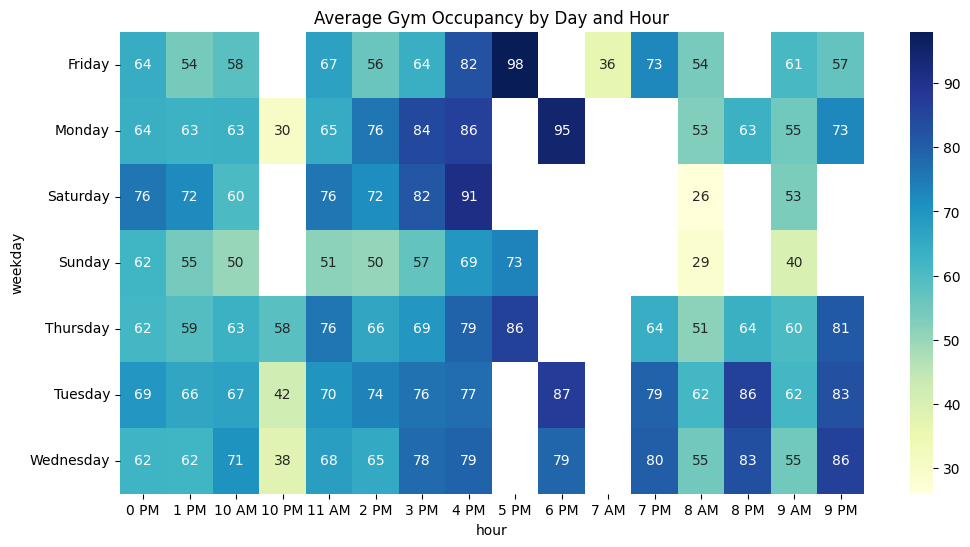

In [7]:
# Visualization example
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_pivot,
    cmap='YlGnBu', annot=True
)
plt.title('Average Gym Occupancy by Day and Hour')